Attempt May 13 2020 on solving schro. eq. for l = 0 orbitals   
Main process:  
1. Set up the system of two 1st order ODEs in odefun     
2. Set the value of energy eigenvalue at a guess value  
3. Feed odefun and energy eigenvalue to the initial value solver (ivp) to integrate the wavefunction   
    ivp solver is analogous to the Verlet algorithm I think
4. Compare the boundary value with the required boundary condition  
5. If the difference is more than a small delta,  
    Adjust* the eigenvalue guess
6. Repeat from step 3 until the difference is less than a small delta  
*we will have to test if we increase or decrease the eigenvalue...

First define the ODE from Eq. 19.8 from Feynman's Lecture - The hydrogen atom

\begin{eqnarray}
\frac{1}{r}\frac{d^2}{dr^2}(r\psi) = -\frac{2m}{\hbar^2}(E + \frac{e^2}{r})\psi \\
\psi(\infty) = 0
\end{eqnarray}

Eq. 19.13 changes the scale of the r and E such that 

\begin{equation}
\frac{d^2f}{d\rho^2} = - (\epsilon + \frac{2}{\rho})f ~~,
\end{equation} 

where 
\begin{eqnarray}
\rho = \frac{r}{r_b} \\
\epsilon = \frac{E}{E_r} \\
f = \rho\psi \\
r_b ~~ \text{is the bohr radius} \\
E_r ~~ \text{is the Rydberg energy}
\end{eqnarray}

Next rewrite the second order equation of f as a first order system and implement its right-hand side evaluation:

\begin{eqnarray}
y_1' = y_2 \\
y_2' = - (\epsilon + \frac{2}{\rho}) y_1
\end{eqnarray}

Here, y_1 and y_2 are intermediate variables equal to f and f'.  
Boundary condition is $f(\infty) = 0$  
The last equality below is directly from rearranging the defined ODE

Now turn that into code  
Write function that returns y_1' and y_2' (relating to f = rho*psi)  
IMPORTANT: we will solve for psi by reconverting f at the end

In [1]:
import numpy as np
def odefun(rho, f, p, n):
    # first unpack the elements in f
    y_1, y_2 = f
    # p is a one element vector that passes the variable 
    epsilon = p*n
    # define the derivative as above
    dy_1dr = y_2
    dy_2dr = - (epsilon + 2/rho)*y_1
    # return the expression of y_1' and y_2' 
    return [dy_1dr, dy_2dr]

Now take a guess at the first eigenvalue: p = 1  
Feed odefun and p = 1 into the ivp solver 

In [4]:
# import necessary packages
import numpy as np
import scipy.integrate 
import scipy as sp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# define initial guess p
# p1, p2  and delta_p should be used to adjust p
p1 = 1.0

# define the boundary condition for f = rho*psi (NOT psi itself)
y_1_0 = 0

# define the rho space
rho = np.linspace(0.1, 20)
# sol takes the results r, rpsi and drpsi/dr solved from the ODE
sol = sp.integrate.solve_ivp(odefun, [0.1, 50, 100], y0=[y_1_0, y_2_0], t_eval=rho, args=(p, 1))
# y_1 takes the first column of rpsi: rpsi
y_1 = sol.y[0]
# boundcalc takes the last element of y_1: last element of rpsi
boundcalc = y_1[-1]

NameError: name 'y_2_0' is not defined

Clearly, we don't have the "velocity" (derivative of the psi)  
We therefore cannot use the ivp solver  
  
What we need is an ODE solver that doesn't need the velocity  
Solution: Verlet algorithm  
As per Matt Frick's summary, it solves ODEs using the taylor expansion  
It can solve an ODE by knowing any two points  
This is perfect for radial potentials because we know the points at far distances are zero  
We will then integrate backwards  

From Matt Frick's summary:  
"The Verlet algorithm is a means of calculating the next entry in a differential equation based on a third order Taylor expansion. Consider a differential equation of the form Ψ′′(x) = F[Ψ(x),x].   
By Taylor expanding about a point x, we can find an approximation for the value of Ψ at a distance δx away:  
Ψ(x + δx) = Ψ(x) + δxΨ′(x) + δx2F [Ψ(x), x] + δx3Ψ′′′(x) + O(δx4),   
Ψ(x − δx) = Ψ(x) − δxΨ′(x) + δx2F [Ψ(x), x] − δx3Ψ′′′(x) + O(δx4).  
Combining these equations to elimate the first and third derivatives, we find  
Ψ(x + δx) = 2Ψ(x) − Ψ(x − δx) + 2δx2F [Ψ(x), x], (30)  
which allows us to determine the next step in a series as long as we know the last two steps. Thus, if we know any two steps in a series we can find all the steps in that series by successive use of equation 30. This allows us to easily determine the radial wavefunction of a spherically symmetric system since we know that the radial wavefunction must tend to zero at infinite distances, or in the case of numerics, “large enough” distances." 

So instead of ivp solver, we formulate the verlet algorithm  
We take the system of taylor expansions:  
  
$f(\rho + d\rho) = f(\rho) + dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} + \frac{dx^3f'''(\rho)}{3!} + ...$  
$f(\rho - d\rho) = f(\rho) - dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} - \frac{dx^3f'''(\rho)}{3!} + ...$ 
  
Adding $f(\rho + d\rho)$ and $f(\rho - d\rho)$ together gives a RHS of:  

$f(\rho + d\rho)$ + $f(\rho - d\rho)$ = $2f(\rho) + 2*\frac{dx^2f''(\rho)}{2!}$
  
Rearranging gives the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2f''(\rho)}{2!}$ 
  
Notice that in our second order ODE,  
  
$f''(\rho) = - (\epsilon + \frac{2}{\rho})f(\rho)$  
  
And so replacing the $f''(\rho)$ in the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2(- (\epsilon + \frac{2}{\rho})f(\rho) )}{2!}$  
  
Thus, if we know a value $f(\rho + d\rho)$ and the value before that, $f(\rho)$, we will know the value at an even earlier point, $f(\rho - d\rho)$.   
  
This allows us to integrate the wavefunction backwards since we know the end values (zero and close to zero)  

Flow chart for defining Verlet function:
1. Set the rho range (called rho) with an increment drho  
2. Initialize an zero list called f to hold the wavefunction - same length as rho  
3. Set the end values of f to be 0 and 10^-10  
4. Define the integration equation from above  
5. Loop over the integration equation, going backwards in index  
6. Normalize f  
7. Return f

Is 1 if theo1 is normalized: 1.000000000000004
Is 1 if theo2 is normalized: 0.9999999999999987
Is 1 if theo3 is normalized: 1.0000000000000018
Is 1 if $\psi$ is normalized: 0.9999999999999964


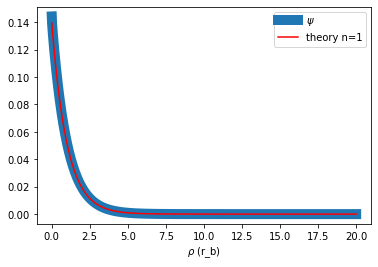

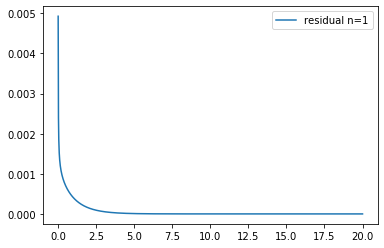

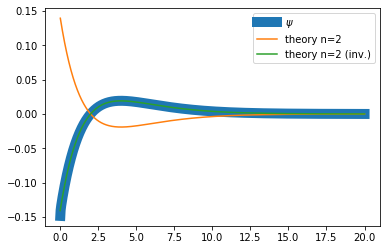

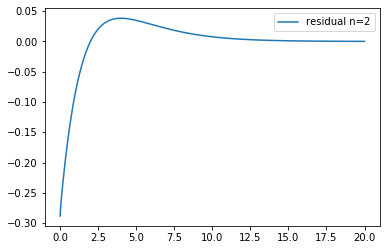

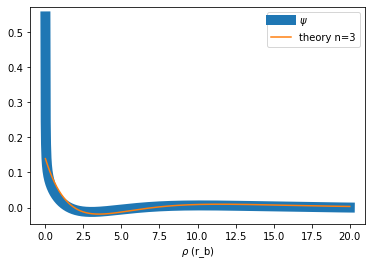

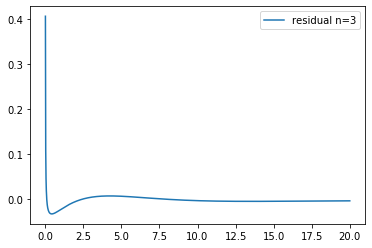

In [111]:
# import packages
import numpy as np
import math

def Verlet(epsilon):
    # defining rho range
    totrho = 2000
    rho_min = 0
    rho_max = 20
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = 0
    f[length - 2] = 10**-10
    
    for i in range(length-2, 1, -1):
        f[i-1] = 2*f[i] - f[i+1] + 2*drho**2*((-epsilon - 2/rho[i])*f[i])/2
    
    #print('this is f', f)
    
    psi= [0]*length
    # solve for psi - wavefunction
    for i in range(1, length, 1):
        psi[i] = f[i]/rho[i]
    
    # normalize the wavefunction f
    # find the total sum (A) of all points of f
    A = 0 
    for i in range(length):
        A += psi[i]**2 # should be some factors of pi likely

    Norm = np.sqrt(A)
    psi = [x/Norm for x in psi]
    return psi # normalized wavefunction  

# Theory calc

# n = 1
# Normalize the analytic solution
theo1 = np.exp(-rho)
A = sum([x**2 for x in theo1])
theo1 = [x/np.sqrt(A) for x in theo1]
# Check the psi normalization
print('Is 1 if theo1 is normalized:', sum([x**2 for x in theo1]))

# n = 2
# Normalize the analytic solution
theo2 = (1 - rho/2)*np.exp(-rho/2)
A = sum([x**2 for x in theo2])
theo2 = [x/np.sqrt(A) for x in theo2]
# Check the psi normalization
print('Is 1 if theo2 is normalized:', sum([x**2 for x in theo2]))

# n = 3
# Normalize the analytic solution
theo3 = (1 - 2*rho/3 + 2*rho**2/27)*np.exp(-rho/3)
A = sum([x**2 for x in theo3])
theo3 = [x/np.sqrt(A) for x in theo3]
# Check the psi normalization
print('Is 1 if theo3 is normalized:', sum([x**2 for x in theo3]))

# Calculate the normalized wavefunction
psi = Verlet(-1)

# Check the psi normalization
print('Is 1 if $\psi$ is normalized:', sum([x**2 for x in psi]))

import matplotlib.pyplot as plt
totrho = 2000
rho_min = 0
rho_max = 20
rho = np.linspace(rho_min, rho_max, totrho)

# plot n = 1
plt.plot(rho[1::], psi[1::], label = '$\psi$', linewidth = 10)
#plt.plot(rho, rho*psi, label = '$\\rho\psi$')
#plt.plot(rho, [i ** 2 for i in rho*psi], label = '$(\\rho\psi)^2$')
plt.plot(rho[1::], theo1[1::], label = 'theory n=1', color = 'r')
plt.xlabel("$\\rho$ (r_b)")
plt.legend()
plt.show()

# calculating and plotting residuals
res1 = np.subtract(psi, theo1)
plt.plot(rho[1::], res1[1::], label = 'residual n=1')
plt.legend()
plt.show()

# plot n = 2
psi = Verlet(-1/4)
plt.plot(rho[1::], psi[1::], label = '$\psi$', linewidth = 10)
plt.plot(rho[1::], theo2[1::], label = 'theory n=2')
plt.plot(rho, [x*-1 for x in theo2], label = 'theory n=2 (inv.)')
plt.legend()
plt.show()

# calculating and plotting residuals
res2 = np.subtract(psi, theo2)
plt.plot(rho[1::], res2[1::], label = 'residual n=2')
plt.legend()
plt.show()

# plot n = 3
psi = Verlet(-1/9)
plt.plot(rho[1::], psi[1::], label = '$\psi$', linewidth = 10)
plt.plot(rho[1::], theo3[1::], label = 'theory n=3')
plt.xlabel("$\\rho$ (r_b)")
plt.legend()
plt.show()

# calculating and plotting residuals
res3 = np.subtract(psi, theo3)
plt.plot(rho[1::], res3[1::], label = 'residual n=3')
plt.legend()
plt.show()

Now that we have the Verlet integrator function, we can use it in the shooting method. 
  
Flowchart for the shooting method:
1. Set an initial guess for the eigenvalue E called E1
2. Set a value called called E2 (for Bisection purposes)
3. Set a dE variable to modify E, where E2 = E1 + dE
4. Calculate f with the initial E1 guess
5. Define delta_0 as the difference between f and required condition at the last index
6. Calculate f again but with E2 guess
7. Define delta_2 as the difference between this f and required condition at the last index
8. If delta_2 is within the tolerance E2 is the answer; break
9. If delta_0 and delta_2 have different signs, bisect
10. E = (E1 + E2)/2 
11. Run Verlet to calculate f again
12. Repeat from step 6
13. If delta_0 and delta_2 have the same sign, then assign E1 = E2 and increment E2 by dE
14. Can check for edge cases along the way

In [69]:
# define initial guess and increments
E1 = -2 
dE = 0.01
E2 = E1 + dE

f = Verlet(E1)

0.04995
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [86]:
A = [1, 2, 3]
B = [3, 2, 1]
A/B

TypeError: unsupported operand type(s) for /: 'list' and 'list'